In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.  

** *File and Data Field Descriptions* **

**train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.  
**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.  
**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.  
**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage.   **Passengers** in cryosleep are confined to their cabins.  
**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.  
**Destination** - The planet the passenger will be debarking to.  
**Age** - The age of the passenger.  
**VIP** - Whether the passenger has paid for special VIP service during the voyage.  
**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.  
**Name** - The first and last names of the passenger.  
**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict  

**test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.  

**sample_submission.csv** - A submission file in the correct format.  
**PassengerId **- Id for each passenger in the test set.  
**Transported **- The target. For each passenger, predict either True or False.  

## 1. Imports

In [1]:
# Imports
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Display input folder contents (data-sets()
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


## 2. Overall dataset information gathering

In [2]:
# Read the training data into a pandas dataframe
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
print("Train shape is {}".format(train.shape))
print("Test shape is {}".format(test.shape))

Train shape is (8693, 14)
Test shape is (4277, 13)


In [3]:
# Checking overall info of the dataset
print(train.head(10))
print(train.describe())
print(train.info())
print(test.head(2))

  PassengerId HomePlanet CryoSleep  Cabin    Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P    TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S    TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S    TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S    TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S    TRAPPIST-1e  16.0  False   
5     0005_01      Earth     False  F/0/P  PSO J318.5-22  44.0  False   
6     0006_01      Earth     False  F/2/S    TRAPPIST-1e  26.0  False   
7     0006_02      Earth      True  G/0/S    TRAPPIST-1e  28.0  False   
8     0007_01      Earth     False  F/3/S    TRAPPIST-1e  35.0  False   
9     0008_01     Europa      True  B/1/P    55 Cancri e  14.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck                Name  \
0          0.0        0.0           0.0     0.0     0.0     Maham Ofracculy   
1        109.0        9.0          25.

Dupes: 0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


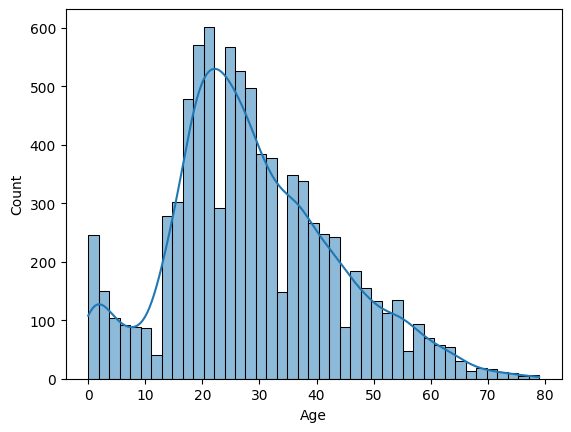

In [4]:
# Check NaN & Dupe values
print("Dupes:", train.duplicated().sum()) # no dupes
sns.histplot(train['Age'], kde=True)
plt.show()

<Axes: ylabel='count'>

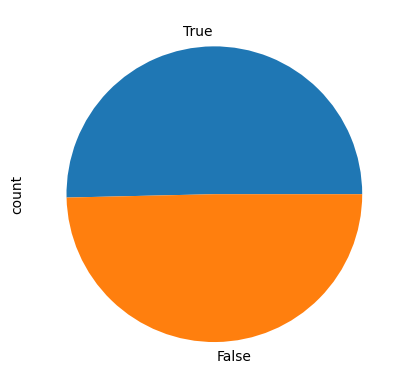

In [5]:
# Plotting how many were transported overall
plot_train = train.Transported.value_counts()
plot_train.plot(kind="pie")

## 3. Data transformation & cleansing

In [6]:
train.isnull().sum().sort_values(ascending=False)
train[["Deck", "Cabin_num", "Side"]] = train["Cabin"].str.split("/", expand=True)
print(len(train))

8693


In [7]:
# Handling missing values etc.
train[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','RoomService']] = train[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','RoomService']].fillna(value=0)
train[["Age"]] = train[["Age"]].fillna
train.drop(["Cabin","Name","Cabin_num","Side", "Age"], axis=1, inplace=True)
train['Transported'] = train['Transported'].astype(int)
train['CryoSleep'] = train['CryoSleep'].astype(int)

train.isnull().sum().sort_values(ascending=False)
print(len(train))

8693


In [8]:
train_encoded = pd.get_dummies(train, columns=["HomePlanet","Destination","Deck"], drop_first=False,prefix='', prefix_sep='')
print(len(train_encoded))

8693


In [9]:
train_encoded.isnull().sum()

PassengerId      0
CryoSleep        0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Transported      0
Earth            0
Europa           0
Mars             0
55 Cancri e      0
PSO J318.5-22    0
TRAPPIST-1e      0
A                0
B                0
C                0
D                0
E                0
F                0
G                0
T                0
dtype: int64

## 4. Splitting & scaling the data

In [10]:
# Dropping unnecessary columns, some str and the target
X = train_encoded.drop(columns=['Transported'])
X.head(5)
y = train_encoded['Transported']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.492, random_state=242)

In [11]:
X_train.head(5)

,PassengerId,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Earth,Europa,...,PSO J318.5-22,TRAPPIST-1e,A,B,C,D,E,F,G,T
6497,6858_03,0,False,0.0,60.0,0.0,310.0,4674.0,False,True,...,False,False,False,True,False,False,False,False,False,False
3498,3757_01,1,False,0.0,0.0,0.0,0.0,0.0,True,False,...,False,True,False,False,False,False,False,False,True,False
501,0539_03,1,False,0.0,0.0,0.0,0.0,0.0,False,False,...,False,False,False,False,True,False,False,False,False,False
6145,6482_03,1,False,0.0,0.0,0.0,0.0,0.0,False,False,...,False,True,False,False,False,False,False,True,False,False
8066,8623_01,0,False,9.0,731.0,85.0,0.0,537.0,True,False,...,False,True,False,False,False,False,False,False,False,False


## 5. Model fitment and accuracy scores

In [12]:
model = LogisticRegression(random_state = 2610, max_iter=500)
model.fit(X_train, y_train)
print(len(X_train))

4416


In [13]:
y_pred = model.predict(X_test)
X_test.head()

,PassengerId,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Earth,Europa,...,PSO J318.5-22,TRAPPIST-1e,A,B,C,D,E,F,G,T
8209,8772_02,0,False,0.0,1127.0,0.0,3939.0,0.0,False,True,...,False,False,False,False,False,False,False,False,False,False
8142,8701_01,0,False,203.0,0.0,172.0,1460.0,151.0,False,False,...,False,False,False,False,False,False,False,True,False,False
6947,7372_01,0,False,2.0,147.0,0.0,1695.0,1147.0,True,False,...,False,True,False,False,False,False,False,True,False,False
2803,3025_01,0,False,2.0,788.0,0.0,128.0,9.0,True,False,...,False,True,False,False,False,False,False,False,True,False
6910,7326_01,0,False,2916.0,0.0,14.0,63.0,0.0,True,False,...,False,True,False,False,False,False,False,True,False,False


In [14]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(len(y_pred))

Accuracy: 0.7776478840308627
4277


In [15]:
sub = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')
sub['Transported'] = list(y_pred)
sub.to_csv('submission.csv', index=False)